# Setup

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account).
2. (Optional) If you would like to do the deep learning component of this tutorial, turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU


In [7]:
!pip install -U pysr
!pip install -U matplotlib

Julia and Julia dependencies are installed at first import:

In [8]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [9]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Simple PySR example:


First, let's learn a simple function

$$f(x) = 2.2\sin(x_0 + 2 x_1) - x_5^2 - 3$$

In [10]:
# Dataset
np.random.seed(0)
X = 10 * np.random.rand(200, 6) - 5
y = 2.2 * np.sin(X[:, 0] + 2 * X[:, 1]) - X[:, 5] ** 2 - 3

y += np.random.normal(0, 0.5, 200)

By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [11]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [12]:
# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-", "^"],
    unary_operators=["exp", "sin"],
    maxsize=15,
    constraints={
        "^": [(-100.0, 100.0), (-100.0, 100.0)]  # Using proper tuple format
    },
    **default_pysr_params,
)

model.fit(X, y)

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         -11.092388   
	1        0.003375                                    -10.955271 - x5   
	2        0.011090                               -11.091976 - sin(x0)   
	3  >>>>  3.096697                              -2.947309 - (x5 * x5)   
	4        0.004586               ((x5 * x5) * -0.9798251) - 3.1116428   
	5        0.002937  (((x5 + 0.04378947) * x5) * -0.97674084) - 3.1...   
	6        0.014852  (x5 * ((x5 * -0.9783928) + (x4 * 0.036650464))...   
	7        0.000502  ((x5 * ((x5 * -0.97367793) - 0.047113497)) - (...   
	8        0.002692  exp((x4 - sin(x0)) + -5.2358) + ((x5 * (x5 * -...   
	
	        loss  complexity  
	0  55.656210           1  
	1  55.281850           3  
	2  54.672173           4  
	3   2.471086           5  
	4   2.448527           7  
	5   2.434188           9  
	6   2.362945          11  
	7   2.359386          14  
	8   2.353042          15  
]

We can print the model, which will print out all the discovered expressions:

In [13]:
model

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         -11.092388   
	1        0.003375                                    -10.955271 - x5   
	2        0.011090                               -11.091976 - sin(x0)   
	3  >>>>  3.096697                              -2.947309 - (x5 * x5)   
	4        0.004586               ((x5 * x5) * -0.9798251) - 3.1116428   
	5        0.002937  (((x5 + 0.04378947) * x5) * -0.97674084) - 3.1...   
	6        0.014852  (x5 * ((x5 * -0.9783928) + (x4 * 0.036650464))...   
	7        0.000502  ((x5 * ((x5 * -0.97367793) - 0.047113497)) - (...   
	8        0.002692  exp((x4 - sin(x0)) + -5.2358) + ((x5 * (x5 * -...   
	
	        loss  complexity  
	0  55.656210           1  
	1  55.281850           3  
	2  54.672173           4  
	3   2.471086           5  
	4   2.448527           7  
	5   2.434188           9  
	6   2.362945          11  
	7   2.359386          14  
	8   2.353042          15  
]

In [14]:
def print_results(model, title):
   print(f"\n{title}")
   print("Trzy najlepsze rozwiązania (według score):")
   best_by_score = model.equations_.sort_values('score', ascending=False).head(3)
   for i, row in best_by_score.iterrows():
      print(f"{i+1}. {row['equation']} (score: {row['score']:.4f}, loss: {row['loss']:.6f})")
    
   print("\nNajlepsze rozwiązanie (best):")
   print(f"1. {model.sympy()}")

In [15]:
print_results(model, "Wyniki modelu PySRRegressor")


Wyniki modelu PySRRegressor
Trzy najlepsze rozwiązania (według score):
4. -2.947309 - (x5 * x5) (score: 3.0967, loss: 2.471086)
7. (x5 * ((x5 * -0.9783928) + (x4 * 0.036650464))) - 3.130253 (score: 0.0149, loss: 2.362945)
3. -11.091976 - sin(x0) (score: 0.0111, loss: 54.672173)

Najlepsze rozwiązanie (best):
1. -x5*x5 - 2.947309


We can also view the SymPy format of the best expression:

In [16]:
model.sympy()

-x5*x5 - 2.947309

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

In [17]:
model.sympy(1)

-x5 - 10.955271

In [18]:
model.sympy(2)

-sin(x0) - 11.091976

In [19]:
model.sympy(3)

-x5*x5 - 2.947309

In [20]:
model.sympy(4)

x5*x5*(-0.9798251) - 1*3.1116428

## Output

`model.equations_` is a Pandas DataFrame. We can export the results in various ways:

In [21]:
model.latex()

'- x_{5} x_{5} - 2.95'

These is also `model.sympy(), model.jax(), model.pytorch()`. All of these can take an index as input, to get the result for an arbitrary equation in the list.

We can also use `model.predict` for arbitrary equations, with the default equation being the one chosen by `model_selection`:

In [22]:
ypredict = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())

Default selection MSE: 2.4710862327590393
Manual selection MSE for index 2: 54.67218131589159


# Custom operators

A full list of operators is given here: https://astroautomata.com/PySR/operators,
but we can also use any binary or unary operator in `julia`, or define our own as arbitrary functions.

Say that we want a command to do quartic powers:

$$ y = x_0^4 - 2 $$

In [23]:
y = X[:, 0] ** 4 - 2

We can do this by passing a string in Julia syntax.

We also define the operator in sympy, with `extra_sympy_mappings`, to enable its use in `predict`, and other export functions.

In [24]:
model = PySRRegressor(
    niterations=5,
    populations=40,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin", "quart(x) = x^4"],
    extra_sympy_mappings={"quart": lambda x: x**4},
)
model.fit(X, y)

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                          142.67906   
	1         8.951517                                          quart(x0)   
	2  >>>>  11.147095                                   quart(x0) + -2.0   
	3         0.019811               -2.259801 + (quart(x0) + 0.25980175)   
	4         0.000670  (quart(x0) + -1.9999992) + (((x0 * x2) + 0.077...   
	5         0.025866  ((x0 * (sin(x2 + 2.0120125) * 2.315244e-6)) + ...   
	
	           loss  complexity  
	0  3.087834e+04           1  
	1  3.999995e+00           2  
	2  8.314109e-10           4  
	3  7.991132e-10           6  
	4  7.959074e-10          12  
	5  7.364821e-10          15  
]

In [25]:
model.sympy()

x0**4 - 2.0

Since `quart` is arguably more complex than the other operators, you can also give it a different complexity, using, e.g., `complexity_of_operators={"quart": 2}` to give it a complexity of 2 (instead of the default 2). You can also define custom complexities for variables and constants (`complexity_of_variables` and `complexity_of_constants`, respectively - both take a single number).


One can also add a binary operator, with, e.g., `"myoperator(x, y) = x^2 * y"`. All Julia operators that work on scalar 32-bit floating point values are available.

Make sure that any operator you add is valid over the real line. So, e.g., you will need to define `"mysqrt(x) = sqrt(abs(x))"` to enable it for negative numbers,
or, simply have it return a very large number for bad inputs (to prevent negative input in a soft way):
`"mysqrt(x::T) where {T} = (x >= 0) ? x : T(-1e9)"` (Julia syntax for a template function of input type `T`), which will make `mysqrt(x)` return -10^9 for negative x–hurting the loss of the equation.

## Scoring

Using `model_selection="best"`selects the equation with the max score and prints it. But in practice it is best to look through all the equations manually, select an equation above some MSE threshold, and then use the score to select among that loss threshold.

Here, "score" is defined by:
$$ \text{score} = - \log(\text{loss}_i/\text{loss}_{i-1})/
(\text{complexity}_i - \text{complexity}_{i-1})$$

This scoring is motivated by the common strategy of looking for drops in the loss-complexity curve.

From Schmidt & Lipson (2009) -

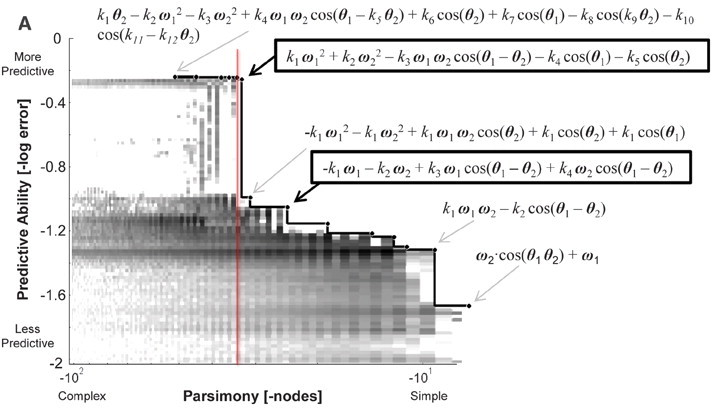

# Noise example

Here is an example with noise. Known Gaussian noise with $\sigma$ between 0.1 and 5.0. We record samples of $y$:

$$ \sigma \sim U(0.1, 5.0) $$
$$ \epsilon \sim \mathcal{N}(0, \sigma^2)$$
$$ y = 5\;\cos(3.5 x_0) - 1.3 + \epsilon.$$
We have 5 features, say. The weights change the loss function to be:
$$MSE = \sum [(y - f(x))^2*w],$$

so in this example, we can set:
$$w = 1/\sigma^2.$$

In [26]:
np.random.seed(0)
N = 3000
upper_sigma = 5
X = 2 * np.random.rand(N, 5)
sigma = np.random.rand(N) * (5 - 0.1) + 0.1
eps = sigma * np.random.randn(N)
y = 5 * np.cos(3.5 * X[:, 0]) - 1.3 + eps

Let's look at this dataset:

Text(0, 0.5, '$y$')

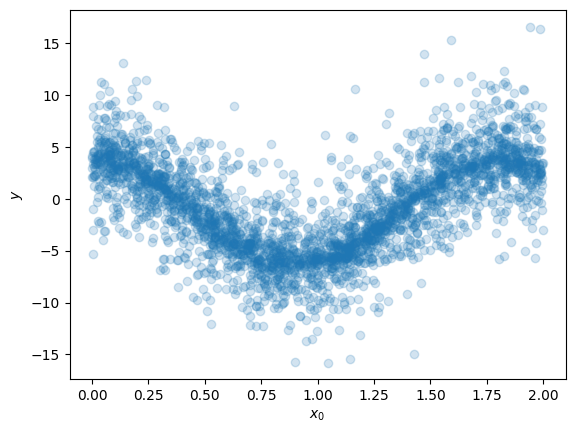

In [27]:
plt.scatter(X[:, 0], y, alpha=0.2)
plt.xlabel("$x_0$")
plt.ylabel("$y$")

Define some weights to use:

In [28]:
weights = 1 / sigma**2

In [29]:
weights[:5]

array([0.25199296, 0.0775419 , 0.11515701, 0.1781281 , 0.0448131 ])

Let's run PySR again:

In [30]:
model = PySRRegressor(
    elementwise_loss="myloss(x, y, w) = w * abs(x - y)",  # Custom loss function with weights.
    niterations=20,
    populations=20,  # Use more populations
    binary_operators=["+", "*"],
    unary_operators=["cos"],
)
model.fit(X, y, weights=weights)

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         -1.1848772   
	1        1.859858e-02                                    x0 + -2.0869555   
	2        1.488129e-01                               cos(x0 * -3.3332388)   
	3        4.617962e-01                    cos(x0 * 3.2905316) * 4.9789724   
	4  >>>>  6.241971e-01        (cos(x0 * 3.49596) * 5.031144) + -1.2891362   
	5        2.399263e-07  (cos(((x0 + x0) * 0.7475167) + (x0 + x0)) * 5....   
	
	       loss  complexity  
	0  3.304065           1  
	1  3.183421           3  
	2  2.743251           4  
	3  1.089317           6  
	4  0.312596           8  
	5  0.312596          14  
]

Let's see if we get similar results to the true equation

In [31]:
model

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         -1.1848772   
	1        1.859858e-02                                    x0 + -2.0869555   
	2        1.488129e-01                               cos(x0 * -3.3332388)   
	3        4.617962e-01                    cos(x0 * 3.2905316) * 4.9789724   
	4  >>>>  6.241971e-01        (cos(x0 * 3.49596) * 5.031144) + -1.2891362   
	5        2.399263e-07  (cos(((x0 + x0) * 0.7475167) + (x0 + x0)) * 5....   
	
	       loss  complexity  
	0  3.304065           1  
	1  3.183421           3  
	2  2.743251           4  
	3  1.089317           6  
	4  0.312596           8  
	5  0.312596          14  
]

We can also filter all equations up to 2x the most accurate equation, then select the best score from that list:

In [32]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)

cos(x0*3.49596)*5.031144 - 1.2891362

We can also use `denoise=True`, which will run the input through a Gaussian process to denoise the dataset, before fitting on it.

Let's look at the fit:

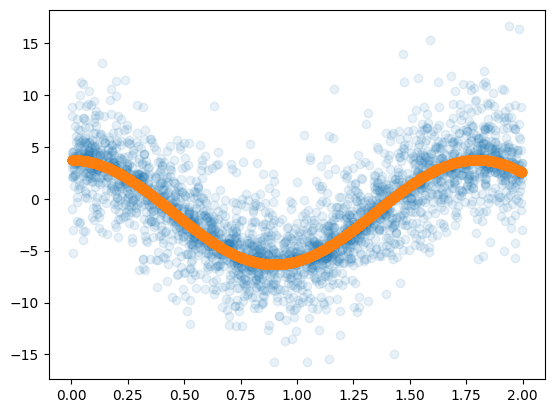

In [33]:
plt.scatter(X[:, 0], y, alpha=0.1)
y_prediction = model.predict(X, index=best_idx)
plt.scatter(X[:, 0], y_prediction)

# Multiple outputs

For multiple outputs, multiple equations are returned:

In [34]:
X = 2 * np.random.randn(100, 5)
y = 1 / X[:, [0, 1, 2]]

In [ ]:
model = PySRRegressor(
    binary_operators=["+", "*"],
    unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
)
model.fit(X, y)

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [ ]:
model

PySRRegressor.equations_ = [
[
	    pick      score                                           equation  \
	0          0.000000                                         -1.3215431   
	1         34.757929                                            inv(x0)   
	2          0.000056                      inv(x0) + (x2 * 4.9927644e-9)   
	3          0.240090                inv((inv(x1) * 2.6055147e-10) + x0)   
	4          0.282602              inv(x0 + (x0 * (x2 * -2.7040517e-8)))   
	5          0.085375    (inv(x0 + 0.08074557) * -2.264129e-9) + inv(x0)   
	6          0.000102  (((x3 + x4) + inv(x0 + 0.08074557)) * -2.26412...   
	7          0.541981  ((inv(x0 + 0.08074557) + inv(0.12519528 * x0))...   
	8          0.000968  ((inv((x2 + x4) + 1.3771124) + inv(x0 + 0.0807...   
	9          0.616009  ((inv(x0 * (x4 * (x4 + 1.3771124))) + inv(x0 +...   
	10         0.021620  inv(x0) + ((inv(x0 + 0.08074557) + inv(x0 * ((...   
	11         0.006945  inv(x0) + ((inv(x0 + 0.08074557) + (inv(x4 * (...   
	12  >>>>   0.438788  inv(x0) + ((inv(x0 + 0.08074557) + (inv(x0 * x...   
	
	            loss  complexity  
	0   4.969471e+01           1  
	1   3.991474e-14           2  
	2   3.990586e-14           6  
	3   3.138822e-14           7  
	4   2.366107e-14           8  
	5   2.172484e-14           9  
	6   2.171596e-14          13  
	7   1.262990e-14          14  
	8   1.260547e-14          16  
	9   3.677059e-15          18  
	10  3.446132e-15          21  
	11  3.375078e-15          24  
	12  1.403322e-15          26  
], [
	    pick      score                                           equation  \
	0          0.000000                                                 x0   
	1         33.224942                                            inv(x1)   
	2          1.721606                               inv(x1) * 0.99999994   
	3          0.986292                  inv(x1 * -1.7080123) * -1.7080123   
	4          0.095218       inv(inv(inv(x1) * -0.58547586)) * -1.7080123   
	5          0.120535           (inv(x1 * x1) * 2.1363875e-10) + inv(x1)   
	6          0.000219  ((x1 + (inv(x1 * x1) * -0.0847489)) * -2.52084...   
	7          0.076763  inv(x1) + ((inv(x2 * -1.5807967) + inv(x1 * x1...   
	8          0.028551  ((inv(x2 * (x3 + -0.66876507)) + inv(x1 * x1))...   
	9   >>>>   0.193941  ((inv(inv(x3 * -1.2629964) + -0.66876507) + in...   
	10         0.026285  inv(x1) + (2.1363875e-10 * (inv(x1 * x1) + inv...   
	11         0.026995  ((inv((x4 + inv(x2)) * (x1 * -0.18332139)) + i...   
	12         0.000642  (((inv(x1 * x1) + inv((inv(x2) + x4) * (x1 * -...   
	13         0.038210  ((((inv(x2) * -1.0128493) + inv(((inv(x2) + x4...   
	14         0.000961  ((((inv(x2) * (x1 * 1.2147022)) + inv(((inv(x2...   
	
	            loss  complexity  
	0   6.278647e+02           1  
	1   2.335916e-12           2  
	2   7.466028e-14           4  
	3   1.038503e-14           6  
	4   8.584244e-15           8  
	5   7.609469e-15           9  
	6   7.602808e-15          13  
	7   7.041034e-15          14  
	8   6.650236e-15          16  
	9   5.477840e-15          17  
	10  5.335732e-15          18  
	11  5.193623e-15          19  
	12  5.186962e-15          21  
	13  4.625189e-15          24  
	14  4.616307e-15          26  
], [
	    pick      score                                           equation  \
	0          0.000000                                          13.143261   
	1         32.484459                                            inv(x2)   
	2          4.998341                             inv(x2 + 7.110647e-11)   
	3          0.112693  inv(x2) + (((x4 + -8.109985) * inv(x2)) * 4.10...   
	4          0.038135  inv(x2) + ((x2 + ((x4 + -8.109985) * inv(x2)))...   
	5          0.001556  (((x2 + -1.138723) + (inv(x2) * (x4 + -8.56016...   
	6          0.017852  (((x2 + (x2 + -1.138723)) + (inv(x2) * (x4 + -...   
	7          0.013924  (5.1221045e-9 * ((x2 + inv(x1 + inv(-1.3473793...   
	8   >>>>   0.057595  ((x4 + (((inv(inv(x2) + x2) * 10.460891) * x2)..

# Julia packages and types

PySR uses [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl)
as its search backend. This is a pure Julia package, and so can interface easily with any other
Julia package.
For some tasks, it may be necessary to load such a package.

For example, let's say we wish to discovery the following relationship:

$$ y = p_{3x + 1} - 5, $$

where $p_i$ is the $i$th prime number, and $x$ is the input feature.

Let's see if we can discover this using
the [Primes.jl](https://github.com/JuliaMath/Primes.jl) package.



`jl` stores the Julia runtime.

Now, let's run some Julia code to add the Primes.jl
package to the PySR environment:

In [ ]:
from pysr import jl

jl.seval(
    """
import Pkg
Pkg.add("Primes")
"""
)

   Resolving package versions...
  No Changes to `C:\Users\micha\.julia\conda\3\x86_64\julia_env\Project.toml`
  No Changes to `C:\Users\micha\.julia\conda\3\x86_64\julia_env\Manifest.toml`


This imports the Julia package manager, and uses it to install
`Primes.jl`. Now let's import `Primes.jl`:

In [ ]:
jl.seval("using Primes: prime")

Note that PySR should automatically load the `juliacall.ipython` extension for you,
which means that you can also execute Julia code in the notebook using the `%%julia` magic:

In [ ]:
%julia using Primes: prime


Now, we define a custom operator:


In [ ]:
jl.seval(
    """
function p(i::T) where T
    if 0.5 < i < 1000
        return T(prime(round(Int, i)))
    else
        return T(NaN)
    end
end
"""
)

p (generic function with 1 method)

Or, equivalently:

In [ ]:
%%julia
function p(i::T) where T
    if 0.5 < i < 1000
        return T(prime(round(Int, i)))
    else
        return T(NaN)
    end
end

p (generic function with 1 method)


We have created a function `p`, which takes a number `i` of type `T` (e.g., `T=Float64`).
`p` first checks whether the input is between 0.5 and 1000.
If out-of-bounds, it returns `NaN`.
If in-bounds, it rounds it to the nearest integer, computes the corresponding prime number, and then
converts it to the same type as input.

The equivalent function in Python would be:

```python
import sympy

def p(i):
    if 0.5 < i < 1000:
        return float(sympy.prime(int(round(i))))
    else:
        return float("nan")
```

(However, note that this version assumes 64-bit float input, rather than any input type `T`)

Next, let's generate a list of primes for our test dataset.
Since we are using juliacall, we can just call `p` directly to do this:


In [ ]:
primes = {i: jl.p(i * 1.0) for i in range(1, 999)}

Next, let's use this list of primes to create a dataset of $x, y$ pairs:

In [ ]:
import numpy as np

X = np.random.randint(0, 100, 100)[:, None]
y = [primes[3 * X[i, 0] + 1] - 5 + np.random.randn() * 0.001 for i in range(100)]

Note that we have also added a tiny bit of noise to the dataset.

Finally, let's create a PySR model, and pass the custom operator. We also need to define the sympy equivalent, which we can leave as a placeholder for now:

In [ ]:
from pysr import PySRRegressor
import sympy


class sympy_p(sympy.Function):
    pass


model = PySRRegressor(
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["p"],
    niterations=20,
    extra_sympy_mappings={"p": sympy_p},
)

We are all set to go! Let's see if we can find the true relation:

In [ ]:
model.fit(X, y)

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.890e+04
Progress: 252 / 620 total iterations (40.645%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.827e+05  1.594e+01  y = 890.43
3           3.145e+03  2.249e+00  y = x₀ * 18.387
5           7.682e+02  7.048e-01  y = (x₀ - 5.1716) * 20.007
7           7.682e+02  1.490e-07  y = ((x₀ - 4.9847) * 20.007) - 3.7411
8           2.500e+01  3.425e+00  y = p(x₀ + (x₀ - (-1.3061 - x₀)))
10          1.104e-06  7.814e+00  y = p((x₀ + (x₀ + 0.87123)) + x₀) + -5
12          1.085e-06  8.833e-03  y = (p(((x₀ + x₀) + x₀) + 1.0934) - 4.9998) * 1
18          1.084e-06  1.156e-04  y = ((p(1.111 + (((x₀ + x₀) - x₀) + (x₀ + x₀))) * 1) + 0.9...
                                      1209) - 5.9119
20          1.084e-06  2.322e-05  y = 1 * ((p((((x₀ - 0.41844) +

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                           890.4339   
	1        2.249288e+00                                     x0 * 18.386473   
	2        7.048106e-01                        (x0 - 5.1717253) * 20.00684   
	3        2.603434e-07        ((x0 - 5.2407556) + 0.06809705) * 20.007109   
	4        3.425204e+00                   p(x0 + (x0 - (-1.3061152 - x0)))   
	5  >>>>  8.467770e+00       p((x0 + (x0 + 0.8712333)) + x0) + -4.9999614   
	6        8.832947e-03  (p(((x0 + x0) + x0) + 1.0933942) - 4.999784) *...   
	7        1.828972e-03  ((p(((x0 + x0) + 0.6394452) + x0) * 0.99999976...   
	
	            loss  complexity  
	0  282735.880000           1  
	1    3145.388200           3  
	2     768.216300           5  
	3     768.215900           7  
	4      24.999779           8  
	5       0.000001          10  
	6       0.000001          12  
	7       0.000001          14  
]

  - outputs\20250508_185405_oo0qb4\hall_of_fame.csv


if all works out, you should be able to see the true relation (note that the constant offset might not be exactly 1, since it is allowed to round to the nearest integer).

You can get the sympy version of the best equation with:

In [ ]:
model.sympy()

sympy_p(x0 + x0 + x0 + 0.8712333) - 4.9999614

# High-dimensional input: Neural Nets + Symbolic Regression

In this example, let's learn a high-dimensional problem. **This will use the method proposed in our NeurIPS paper: https://arxiv.org/abs/2006.11287.**

Let's consider a time series problem:

$$ z = y^2,\quad y = \frac{1}{10} \sum(y_i),\quad y_i = x_{i0}^2 + 6 \cos(2*x_{i2})$$

Imagine our time series is 10 timesteps. That is very hard for symbolic regression, even if we impose the inductive bias of $$z=f(\sum g(x_i))$$ - it is the square of the number of possible equations!

But, as in our paper, **we can break this problem down into parts with a neural network. Then approximate the neural network with the symbolic regression!**

Then, instead of, say, $(10^9)^2=10^{18}$ equations, we only have to consider $2\times 10^9$ equations.

In [ ]:
import numpy as np

rstate = np.random.RandomState(0)

N = 100000
Nt = 10
X = 6 * rstate.rand(N, Nt, 5) - 3
y_i = X[..., 0] ** 2 + 6 * np.cos(2 * X[..., 2])
y = np.sum(y_i, axis=1) / y_i.shape[1]
z = y**2
X.shape, y.shape

((100000, 10, 5), (100000,))

## Neural Network definition

So, as described above, let's first use a neural network with the sum inductive bias to solve this problem.

Essentially, we will learn two neural networks:
- `f`
- `g`

each defined as a multi-layer perceptron. We will sum over `g` the same way as in our equation, but we won't define the summed part beforehand.

Then, we will fit `g` and `f` **separately** using symbolic regression.

> **Warning**
>
> We import torch *after* already starting PyJulia. This is required due to interference between their C bindings. If you use torch, and then run PyJulia, you will likely hit a segfault. So keep this in mind for mixed deep learning + PyJulia/PySR workflows.

In [ ]:
!pip install pytorch_lightning

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

hidden = 128
total_steps = 50_000


def mlp(size_in, size_out, act=nn.ReLU):
    return nn.Sequential(
        nn.Linear(size_in, hidden),
        act(),
        nn.Linear(hidden, hidden),
        act(),
        nn.Linear(hidden, hidden),
        act(),
        nn.Linear(hidden, size_out),
    )


class SumNet(pl.LightningModule):
    def __init__(self):
        super().__init__()

        ########################################################
        # The same inductive bias as above!
        self.g = mlp(5, 1)
        self.f = mlp(1, 1)

    def forward(self, x):
        y_i = self.g(x)[:, :, 0]
        y = torch.sum(y_i, dim=1, keepdim=True) / y_i.shape[1]
        z = self.f(y)
        return z[:, 0]

    ########################################################

    # PyTorch Lightning bookkeeping:
    def training_step(self, batch, batch_idx):
        x, z = batch
        predicted_z = self(x)
        loss = F.mse_loss(predicted_z, z)
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.max_lr)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.max_lr,
                total_steps=self.trainer.estimated_stepping_batches,
                final_div_factor=1e4,
            ),
            "interval": "step",
        }
        return [optimizer], [scheduler]

## Data bookkeeping

Put everything into PyTorch and do a train/test split:

In [ ]:
from multiprocessing import cpu_count

Xt = torch.tensor(X).float()
zt = torch.tensor(z).float()
X_train, X_test, z_train, z_test = train_test_split(Xt, zt, random_state=0)
train_set = TensorDataset(X_train, z_train)
train = DataLoader(
    # train_set, batch_size=128, num_workers=cpu_count(), shuffle=True, pin_memory=True
    train_set, batch_size=128, num_workers=0, shuffle=True, pin_memory=True
)
test_set = TensorDataset(X_test, z_test)
# test = DataLoader(test_set, batch_size=256, num_workers=cpu_count(), pin_memory=True)
test = DataLoader(test_set, batch_size=256, num_workers=0, pin_memory=True)

## Train the model with PyTorch Lightning on GPUs:

Start the model:

In [ ]:
pl.seed_everything(0)
model = SumNet()
model.total_steps = total_steps
model.max_lr = 1e-2

Seed set to 0


PyTorch Lightning trainer object:

In [ ]:
trainer = pl.Trainer(max_steps=total_steps, accelerator="cpu", devices=1)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Here, we fit the neural network:

In [ ]:
trainer.fit(model, train_dataloaders=train, val_dataloaders=test)


  | Name | Type       | Params | Mode 
--------------------------------------------
0 | g    | Sequential | 33.9 K | train
1 | f    | Sequential | 33.4 K | train
--------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50000` reached.


## Latent vectors of network

Let's get the input and output of the learned `g` function from the network over some random data:

In [ ]:
np.random.seed(0)
idx = np.random.randint(0, 10000, size=1000)

X_for_pysr = Xt[idx]
y_i_for_pysr = model.g(X_for_pysr)[:, :, 0]
y_for_pysr = torch.sum(y_i_for_pysr, dim=1) / y_i_for_pysr.shape[1]
z_for_pysr = zt[idx]  # Use true values.

X_for_pysr.shape, y_i_for_pysr.shape

(torch.Size([1000, 10, 5]), torch.Size([1000, 10]))

## Learning over the network:

Now, let's fit `g` using PySR.

> **Warning**
>
> First, let's save the data, because sometimes PyTorch and juliacall's C bindings interfere and cause the colab kernel to crash. If we need to restart, we can just load the data without having to retrain the network:

In [ ]:
nnet_recordings = {
    "g_input": X_for_pysr.detach().cpu().numpy().reshape(-1, 5),
    "g_output": y_i_for_pysr.detach().cpu().numpy().reshape(-1),
    "f_input": y_for_pysr.detach().cpu().numpy().reshape(-1, 1),
    "f_output": z_for_pysr.detach().cpu().numpy().reshape(-1),
}

# Save the data for later use:
import pickle as pkl

with open("nnet_recordings.pkl", "wb") as f:
    pkl.dump(nnet_recordings, f)

We can now load the data, including after a crash (be sure to re-run the import cells at the top of this notebook, including the one that starts juliacall).

In [ ]:
import pickle as pkl

nnet_recordings = pkl.load(open("nnet_recordings.pkl", "rb"))
f_input = nnet_recordings["f_input"]
f_output = nnet_recordings["f_output"]
g_input = nnet_recordings["g_input"]
g_output = nnet_recordings["g_output"]

And now fit using a subsample of the data (symbolic regression only needs a small sample to find the best equation):

In [ ]:
rstate = np.random.RandomState(0)
f_sample_idx = rstate.choice(f_input.shape[0], size=500, replace=False)

model = PySRRegressor(
    niterations=50,
    binary_operators=["+", "-", "*"],
    unary_operators=["cos", "square"],
)
model.fit(g_input[f_sample_idx], g_output[f_sample_idx])

c:\Users\micha\.julia\conda\3\x86_64\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.890e+04
Progress: 250 / 1550 total iterations (16.129%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.103e+02  1.594e+01  y = -2.7925
2           2.090e+02  6.424e-03  y = square(x₀)
4           1.577e+02  1.407e-01  y = cos(x₀) * -11.523
6           6.337e+01  4.560e-01  y = cos(x₂ * 1.9636) * 18.429
8           6.108e+01  1.840e-02  y = (cos(x₂ * 1.992) * 18.048) - 1.6627
10          6.056e+01  4.252e-03  y = (cos(-0.054513 - (x₂ * 1.9944)) * 18.042) - 1.6857
13          5.413e+00  8.049e-01  y = (cos(x₂ * 2.0001) * 17.985) - ((4.3725 - square(x₀)) *...
                                       2.4025)
15          8.639e-03  3.220e+00  y = (cos(x₂ * 2.0001) * 17.985) - ((4.3725 - (square(x₀) *...
                                       1.2468)

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          -2.792466   
	1         0.006424                                         square(x0)   
	2         0.140698                               cos(x0) * -11.523808   
	3         0.455966                    cos(x2 * 1.9634963) * 18.429392   
	4         0.018395       (cos(x2 * 1.9920154) * 18.04762) - 1.6621752   
	5         1.401808         (cos(x2 * 2.015361) - cos(x0)) * 14.812658   
	6         0.056861  ((cos(2.037428 * x2) - cos(x0)) * 14.733613) +...   
	7         0.509390  (cos(x2 * 2.038163) + cos(cos(x0) + 8.004994))...   
	8   >>>>  6.838690  (cos(x2 * 2.000067) * 17.985027) - ((square(x0...   
	9         0.000002  (-4.376363 + ((square(x0) * 2.9953473) - 6.128...   
	10        0.001266  (cos(x2 * 2.0000606) * 17.98508) - (10.505211 ...   
	11        0.022109  (cos(x2 * 2.0000443) * 17.986298) - ((x1 * 0.0...   
	12        0.000933  (x3 * -0.003260433) + ((cos(x2 * 2.0000443) * ...   
	13        0.011323  (cos(x2 * 2.0000582) * 17.98531) - (((cos(x2 *...   
	14        0.000231  (cos(x2 * 2.000073) * 17.985523) + (-4.215495 ...   
	15        0.001496  (cos(x2 * 2.0000582) * 17.98531) - ((((x3 * 0....   
	16        0.005617  (cos(x2 * 2.0000877) * 17.985113) - (((x1 + ((...   
	
	          loss  complexity  
	0   210.328350           1  
	1   208.981570           2  
	2   157.724600           4  
	3    63.365460           6  
	4    61.076584           8  
	5    15.034094           9  
	6    13.418033          11  
	7     8.062384          12  
	8     0.008639          13  
	9     0.008639          15  
	10    0.008628          16  
	11    0.008439          17  
	12    0.008408          21  
	13    0.008313          22  
	14    0.008309          24  
	15    0.008285          26  
	16    0.008192          28  
]

  - outputs\20250508_190535_IJOM8V\hall_of_fame.csv


If this segfaults, restart the notebook, and run the initial imports and juliacall part, but skip the PyTorch training. This is because PyTorch's C binding tends to interefere with juliacall. You can then re-run the `pkl.load` cell to import the data.

## Validation

Recall we are searching for $f$ and $g$ such that:
$$z=f(\sum g(x_i))$$
which approximates the true relation:
$$ z = y^2,\quad y = \frac{1}{10} \sum(y_i),\quad y_i = x_{i0}^2 + 6 \cos(2 x_{i2})$$

Let's see how well we did in recovering $g$:

In [ ]:
model.equations_[["complexity", "loss", "equation"]]

,complexity,loss,equation
0,1,210.328350,-2.792466
1,2,208.981570,square(x0)
2,4,157.724600,cos(x0) * -11.523808
3,6,63.365460,cos(x2 * 1.9634963) * 18.429392
4,8,61.076584,(cos(x2 * 1.9920154) * 18.04762) - 1.6621752
5,9,15.034094,(cos(x2 * 2.015361) - cos(x0)) * 14.812658
6,11,13.418033,((cos(2.037428 * x2) - cos(x0)) * 14.733613) +...
7,12,8.062384,(cos(x2 * 2.038163) + cos(cos(x0) + 8.004994))...
8,13,0.008639,(cos(x2 * 2.000067) * 17.985027) - ((square(x0...
9,15,0.008639,(-4.376363 + ((square(x0) * 2.9953473) - 6.128...


A neural network can easily undo a linear transform (which commutes with the summation), so any affine transform in $g$ is to be expected. The network for $f$ has learned to undo the linear transform.

This likely won't find the exact result, but it should find something similar. You may wish to try again but with many more `total_steps` for the neural network (10,000 is quite small!).

Then, we can learn another analytic equation for $f$.

**Now, we can compose these together to get the time series model!**

Think about what we just did: we found an analytical equation for $z$ in terms of $500$ datapoints, under the assumption that $z$ is a function of a sum of another function over an axis:

$$ z = f(\sum_i g(x_i)) $$

And we pulled out analytical copies for $g$ using symbolic regression.

# Other PySR Options

The full list of PySR parameters can be found here: https://astroautomata.com/PySR/api